In [3]:
import torch
from utils.setup import GetCustomProteinDatasetPadded, GetCVProteins
import torch.nn as nn
import matplotlib.pyplot as plt
import utils.metrics_utils as mu
import numpy as np
from sklearn import metrics
import torch.optim as optim
import torchvision.transforms as T

encode_length = 1500

# Create the dataset cunstructor (use encode_length to set the dimension of the encoded proteins)
CustomProteinDataset = GetCustomProteinDatasetPadded(encode_length)
CVProteins = GetCVProteins()

# Model
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.num_classes = num_classes
        self.channels = 512
        self.length = 1500
        self.hidden1 = 128
        batchnorm = nn.BatchNorm1d
        
        # self.transform = T.GaussianBlur( kernel_size=[1,31], sigma=7.0 )

        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv1d(self.channels, self.hidden1, 9, padding=4),
            batchnorm(self.hidden1),
            activation_fn(),
            nn.Conv1d(self.hidden1, 20, 7, padding=3),
        )

        self.linear = nn.Linear(20, self.num_classes)


        # Convolution
        in_channels = self.num_classes
        out_channels = in_channels

        groups = in_channels

        kernel_width = 7
        kernel_std = 1

        kernel1D = torch.tensor(gaussian(kernel_width, kernel_std)).float()
        weights = torch.stack( [torch.zeros(kernel_width) for i in range((in_channels//groups-1)//2)] + [kernel1D] + [torch.zeros(kernel_width) for i in range((in_channels//groups-1)//2)])
        self.smoothing_weights = torch.stack(  [weights for i in range(out_channels)]  )
        self.smoothing_groups = groups

        
        # result = torch.nn.functional.conv1d(inputs, weights, padding="same", groups = groups)

    def forward(self, x):
        x = self.net(x)


        x = torch.transpose(x,1,2)
        x = self.linear(x)
        x = torch.transpose(x,1,2)

        # print(x.shape)

        x = torch.nn.functional.pad(x, ((self.smoothing_weights.shape[-1]-1 )//2,(self.smoothing_weights.shape[-1]-1 )//2), mode = "reflect")
        x = torch.nn.functional.conv1d(x, self.smoothing_weights, groups = self.smoothing_groups)
        
        return x


# Accuracy
def accuracy(target, pred):
    return metrics.accuracy_score(
        target.detach().cpu().numpy(), pred.detach().cpu().numpy()
    )

print_error_type_pairs = False

def gaussian(M, std, sym=True):
    if M < 1:
        return np.array([])
    if M == 1:
        return np.ones(1, 'd')
    odd = M % 2
    if not sym and not odd:
        M = M + 1
    n = np.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = np.exp(-n ** 2 / sig2) /np.sqrt(2*np.pi)/std
    if not sym and not odd:
        w = w[:-1]
    return w

In [4]:
# Initiate the model
n_unique_labels = 7
model = Model(n_unique_labels)

# Loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


# Setup datasets
cv0Indices = CVProteins["cv0"]
train_dataset = CustomProteinDataset(cv0Indices[0:553])
test_dataset = CustomProteinDataset(cv0Indices[553:691])

batch_size = 32
# define a data loader to iterate the dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

num_epochs = 20
validation_every_steps = 50

step = 0
model.train()

train_accuracies = []
valid_accuracies = []


step_history = []
type_accuracy_history = []

tm_type_accuracy_history = []
sptm_type_accuracy_history = []
sp_type_accuracy_history = []
glob_type_accuracy_history = []
beta_type_accuracy_history = []

tm_topology_accuracy_history = []
sptm_topology_accuracy_history = []
sp_topology_accuracy_history = []
glob_topology_accuracy_history = []
beta_topology_accuracy_history = []

print("Running Training loop")

for epoch in range(num_epochs):
    train_accuracies_batches = []

    for batch in train_loader:
        inputs, targets = batch
        output = model(inputs[:, :-1, :])

        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy
        predictions = output.max(1)[1]

        # Calculate accuracy for each protein in batch
        # prediction_labels_list = []
        # target_labels_list = []
        for idx in range(predictions.shape[0]):
            target_len = int(torch.sum(inputs[idx, -1, :]))
            train_accuracies_batches.append(
                accuracy(targets[idx][0:target_len], predictions[idx][0:target_len])
            )

        if step % validation_every_steps == 0:
            # Append everage training accuracy to list
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compite accuracies on validation set
            valid_accuracies_batches = []

            # For confusion matrix
            prediction_labels_list = []
            target_labels_list = []

            with torch.no_grad():
                model.eval()
                # Change this to test_loader once this exists
                for batch_test in test_loader:
                    inputs, targets = batch_test

                    # inputs, targets = inputs.to(DEVICE), targets.to(DEVICE) # Probably change this!!
                    output = model(inputs[:, :-1, :])
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    for idx in range(predictions.shape[0]):
                        # target_len represents the length of the targets non padded length
                        target_len = int(torch.sum(inputs[idx, -1, :]))

                        valid_accuracies_batches.append(
                            accuracy(
                                targets[idx][0:target_len],
                                predictions[idx][0:target_len],
                            )
                        )

                        temp = predictions[idx][0:target_len]
                        temp[temp == 6] = -1
                        prediction_labels_list += [temp]
                        target_labels_list += [targets[idx][0:target_len]]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    # valid_accuracies_batches.append(
                    #     accuracy(targets[0:500], predictions[0:500]) * len(inputs)
                    # )

                    model.train()

            # Calcucalte and prind confusion matrix

            valid_accuracies.append(
                np.sum(valid_accuracies_batches) / len(test_dataset)
            )
            print(f"Step {step:<5}")
            print(f"  training accuracy:    {train_accuracies[-1]}")
            print(f"  test accuracy:        {valid_accuracies[-1]}")

            # Extra accuracies
            (
                error_type_pairs,
                confusion_matrix,
                type_accuracy,
                detailed_type_accuracy,
            ) = mu.confusionMatrix(prediction_labels_list, target_labels_list)

            # type accuracy is average of per type, topology accuracy
            print(f"  type accuracy (test): {type_accuracy}")

            # detailed type accuracies
            for key in detailed_type_accuracy.keys():
                print(f"  {key}")
                for field in detailed_type_accuracy[key].keys():
                    print(f"    {field:<9}: {detailed_type_accuracy[key][field]}")

            print(confusion_matrix)

            if print_error_type_pairs:
                for error_pair in error_type_pairs:
                    print("  Predicted topology:", error_pair["predicted topology"])
                    print("  Target topology:   ", error_pair["target topology"])

            print("")

            # Store values for plot
            step_history += [step]
            type_accuracy_history += [type_accuracy]

            tm_type_accuracy_history += [detailed_type_accuracy["tm"]["type"]]
            sptm_type_accuracy_history += [detailed_type_accuracy["sptm"]["type"]]
            sp_type_accuracy_history += [detailed_type_accuracy["sp"]["type"]]
            glob_type_accuracy_history += [detailed_type_accuracy["glob"]["type"]]
            beta_type_accuracy_history += [detailed_type_accuracy["beta"]["type"]]

            tm_topology_accuracy_history += [detailed_type_accuracy["tm"]["topology"]]
            sptm_topology_accuracy_history += [detailed_type_accuracy["sptm"]["topology"]]
            sp_topology_accuracy_history += [detailed_type_accuracy["sp"]["topology"]]
            glob_topology_accuracy_history += [detailed_type_accuracy["glob"]["topology"]]
            beta_topology_accuracy_history += [detailed_type_accuracy["beta"]["topology"]]


print("Done training.")

encoding proteins


553it [00:02, 227.48it/s]


encoding proteins


138it [00:00, 178.76it/s]


Running Training loop
Step 50   
  training accuracy:    0.808802074685265
  test accuracy:        0.7979628242982272
  type accuracy (test): 0.5192788243293762
  tm
    type     : 0.6428571343421936
    topology : 0.0
  sptm
    type     : 0.75
    topology : 0.0
  sp
    type     : 0.7837837934494019
    topology : 0.7837837934494019
  glob
    type     : 0.4197530746459961
    topology : 0.4197530746459961
  beta
    type     : 0.0
    topology : 0.0
tensor([[ 9,  1,  2,  1,  0,  0,  1],
        [ 1,  3,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  1,  0, 29,  6],
        [ 2,  2,  6,  0,  0, 34, 37],
        [ 0,  2,  0,  0,  0,  0,  0]])



KeyboardInterrupt: 

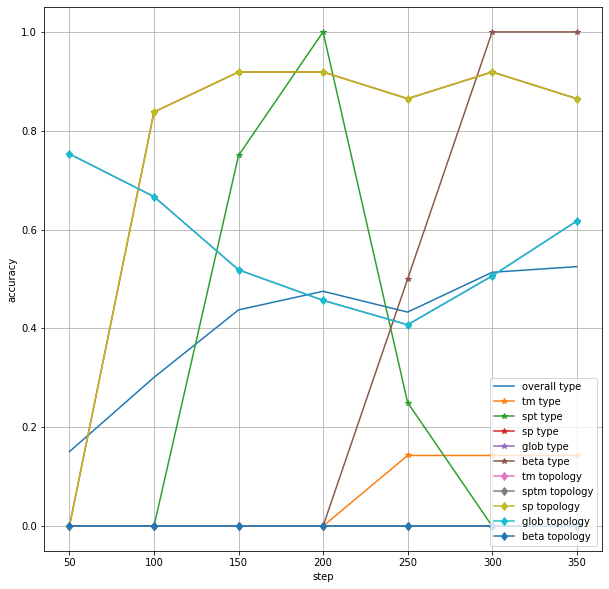

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))

axs.plot(step_history,type_accuracy_history,label="overall type")

axs.plot(step_history,tm_type_accuracy_history, "-*", label="tm type")
axs.plot(step_history,sptm_type_accuracy_history, "-*", label="spt type")
axs.plot(step_history,sp_type_accuracy_history, "-*", label="sp type")
axs.plot(step_history,glob_type_accuracy_history, "-*", label="glob type")
axs.plot(step_history,beta_type_accuracy_history, "-*", label="beta type")

axs.plot(step_history,tm_topology_accuracy_history, "-d", label="tm topology")
axs.plot(step_history,sptm_topology_accuracy_history, "-d", label="sptm topology")
axs.plot(step_history,sp_topology_accuracy_history, "-d", label="sp topology")
axs.plot(step_history,glob_topology_accuracy_history, "-d", label="glob topology")
axs.plot(step_history,beta_topology_accuracy_history, "-d", label="beta topology")


axs.set_xlabel("step")
axs.set_ylabel("accuracy")
axs.grid(True)

plt.legend(loc="lower right")
plt.show()

In [ ]:
inputs = torch.randn(40,1, 30)
filters = torch.randn(20, 16, 401)
torch.nn.functional.conv1d(inputs, filters, padding='same').shape

RuntimeError: Given groups=1, weight of size [20, 16, 401], expected input[40, 1, 30] to have 16 channels, but got 1 channels instead

In [ ]:
in_channels = 5
inputs = torch.randn(10,in_channels, 10)
out_channels = in_channels

groups = in_channels

kernel_width = 7
kernel_std = 1

kernel1D = torch.tensor(gaussian(kernel_width, kernel_std)).float()
weights = torch.stack( [torch.zeros(kernel_width) for i in range((in_channels//groups-1)//2)] + [kernel1D] + [torch.zeros(kernel_width) for i in range((in_channels//groups-1)//2)])
weights = torch.stack(  [weights for i in range(out_channels)]  )


In [ ]:
weights

tensor([[[0.0044, 0.0540, 0.2420, 0.3989, 0.2420, 0.0540, 0.0044]],

        [[0.0044, 0.0540, 0.2420, 0.3989, 0.2420, 0.0540, 0.0044]],

        [[0.0044, 0.0540, 0.2420, 0.3989, 0.2420, 0.0540, 0.0044]],

        [[0.0044, 0.0540, 0.2420, 0.3989, 0.2420, 0.0540, 0.0044]],

        [[0.0044, 0.0540, 0.2420, 0.3989, 0.2420, 0.0540, 0.0044]]])

In [ ]:
# print(inputs.shape)
# inputs_pad = torch.nn.functional.pad(inputs,((kernel_width-1)//2,(kernel_width-1)//2))

In [ ]:
result = torch.nn.functional.conv1d(inputs, weights, padding="same", groups = groups)
print(result.shape)

torch.Size([10, 5, 10])


In [ ]:
inputs[0,0,:]

tensor([ 1.9816,  0.2271,  2.0288, -0.5102, -1.6168, -1.1106, -0.4445, -1.8825,
         1.4215, -0.2126])

In [ ]:
result[0,0,:]

tensor([ 0.8455,  1.0610,  0.7409, -0.1039, -1.0372, -0.9418, -0.9016, -0.5146,
         0.0602,  0.2592])

In [ ]:
B = np.array([1.9816,  0.2271,  2.0288])

A = np.array([0.24197072, 0.3989423 , 0.24197072])

(A*B).sum()

1.060999171818